In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import *
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import copy
from torch.optim import lr_scheduler
%matplotlib inline

In [11]:
EPOCHS = 200
EPOCH_PATIENCE = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.01
NUM_CLASSES = 102

In [12]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        # Convolutional layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 2056),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2056, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, NUM_CLASSES),
        )

    def forward(self, X):
        X = self.features(X)
        X = X.view(X.size(0), -1)  # Flatten the features:
        X = self.classifier(X)
        return X


In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=NUM_CLASSES):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [14]:
def update_transform(epoch):
    new_transform = copy.deepcopy(train_transform)
    
    # Basic transformations
    if epoch > 20:
        new_transform.transforms.insert(0, RandomVerticalFlip(p=0.5))
        new_transform.transforms.insert(1, RandomRotation(degrees=15))  # Adjusted rotation
    if epoch > 30:
        new_transform.transforms[1] = RandomRotation(degrees=30)  # Gradual increase in rotation
    
    # Intermediate transformations
    if epoch > 40:
        new_transform.transforms.insert(3, ColorJitter(brightness=0.02, contrast=0.02))  # Gradual color jitter
    if epoch > 45:
        new_transform.transforms.insert(4, RandomAffine(degrees=0, translate=(0.02, 0.02)))  # Gradual affine
    
    # Advanced transformations
    if epoch > 50:
        new_transform.transforms.insert(5, RandomPerspective(distortion_scale=0.1, p=0.1))  # Gradual perspective
    if epoch > 60:
        new_transform.transforms.insert(6, GaussianBlur(kernel_size=(3, 5), sigma=(0.01, 1)))  # Gradual blur
    
    # Sharpness and saturation adjustments
    if epoch > 70:
        new_transform.transforms[3] = ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05)  # Gradual adjustments
    if epoch > 80:
        new_transform.transforms[3] = ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01)  # Gradual adjustments
    
    # Scaling up color jitter
    if epoch > 90:
        new_transform.transforms[3] = ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02)  # Gradual adjustments
    
    return new_transform

In [15]:
train_transform = Compose([
    Resize((256, 256)),
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    RandomRotation(30),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210])
])

val_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210]),
])

test_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210]),
])

In [16]:
train_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=train_transform)
val_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='val', download=True, transform=val_transform)
test_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='test', download=True, transform=test_transform)

In [17]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
#model = ConvolutionalNetwork()
model = ResNet(ResidualBlock, [2, 2, 2, 2])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [19]:
import time

start_time = time.time()

# Create Variables To Tracks Things
epochs = EPOCHS
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Early Stopping Parameters
patience = EPOCH_PATIENCE  # How many epochs to wait after val loss has stopped improving
min_val_loss = float('inf')  # Initialize to infinity
stale_epochs = 0  # Counter for epochs without improvement

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    #current_transform = update_transform(i)  # Get the updated transform for the current epoch
    #train_data.transform = current_transform  # Update the transform in the dataset
    #train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)  # Recreate the DataLoader with the updated dataset

    # Train
    for b, (X_train, y_train) in enumerate(train_loader, 1):
        X_train, y_train = X_train.to(device), y_train.to(device)
        y_pred = model(X_train)  # get predicted values from the training set. Not flattened 2D
        loss = criterion(y_pred, y_train)  # how off are we? Compare the predictions to correct answers in y_train

        predicted = torch.max(y_pred.data, 1)[
            1]  # add up the number of correct predictions. Indexed off the first point
        batch_corr = (predicted == y_train).sum()  # how many we got correct from this batch. True = 1, False=0, sum those up
        trn_corr += batch_corr  # keep track as we go along in training.

        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

            # Print out some results
        if b % BATCH_SIZE == 0:
            print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad():
        val_loss = 0
        for b, (X_test, y_test) in enumerate(val_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            val_loss += criterion(y_val, y_test).item()  # Sum up the loss from each batch

    avg_val_loss = val_loss / len(val_loader)  # Calculate the average loss
    loss = criterion(y_val, y_test)

    test_losses.append(loss)
    test_correct.append(tst_corr)

    # Early Stopping Check
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        stale_epochs = 0  # Reset the stale epochs counter
        best_model_state = model.state_dict()
    else:
        stale_epochs += 1  # Increment the stale epochs counter
        if stale_epochs >= patience:
            print(f'Stopping early at epoch {i} due to overfitting.')
            model.load_state_dict(best_model_state)
            break  # Break out of the loop
    
    scheduler.step(val_loss)
    print(f'Epoch: {i} Validation Loss: {avg_val_loss} Current lr: {scheduler.get_last_lr()}')


current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total / 60} minutes!')


Epoch: 0  Batch: 16  Loss: 5.060618877410889
Epoch: 0  Batch: 32  Loss: 4.726531982421875
Epoch: 0  Batch: 48  Loss: 4.590764999389648
Epoch: 0  Batch: 64  Loss: 4.581584930419922
Epoch: 0 Validation Loss: 4.631511025130749 Current lr: [0.01]
Epoch: 1  Batch: 16  Loss: 4.669458389282227
Epoch: 1  Batch: 32  Loss: 4.510268688201904
Epoch: 1  Batch: 48  Loss: 4.442182540893555
Epoch: 1  Batch: 64  Loss: 4.324915885925293
Epoch: 1 Validation Loss: 4.672985389828682 Current lr: [0.01]
Epoch: 2  Batch: 16  Loss: 4.387202739715576
Epoch: 2  Batch: 32  Loss: 4.497416019439697
Epoch: 2  Batch: 48  Loss: 4.565796852111816
Epoch: 2  Batch: 64  Loss: 4.532634735107422
Epoch: 2 Validation Loss: 4.713886469602585 Current lr: [0.01]
Epoch: 3  Batch: 16  Loss: 4.238525390625
Epoch: 3  Batch: 32  Loss: 3.9739582538604736
Epoch: 3  Batch: 48  Loss: 4.169493675231934
Epoch: 3  Batch: 64  Loss: 3.979461431503296
Epoch: 3 Validation Loss: 4.732414059340954 Current lr: [0.01]
Epoch: 4  Batch: 16  Loss: 3.8

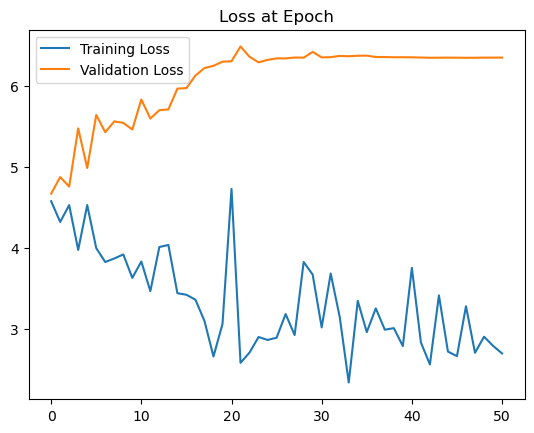

In [20]:
# Convert GPU tensors to CPU tensors, detach them from the computation graph, and then to NumPy arrays
train_losses = [tl.cpu().detach().numpy() for tl in train_losses]
test_losses = [tl.cpu().detach().numpy() for tl in test_losses]

# Now you can plot using matplotlib
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()
plt.show(block=True)

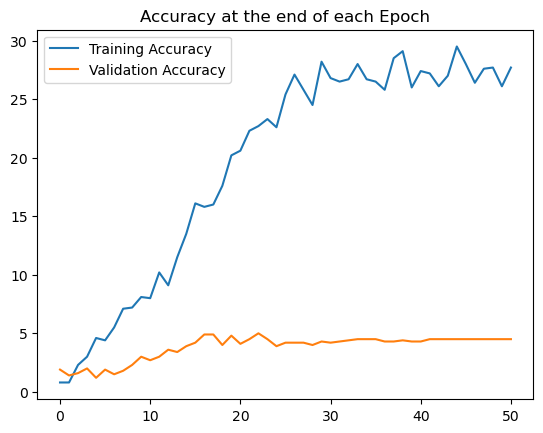

In [21]:
plt.plot([t.cpu()/10 for t in train_correct], label="Training Accuracy")
plt.plot([t.cpu()/10 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [22]:
from torch.utils.data import DataLoader

test_load_everything = DataLoader(test_data, batch_size=1024, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for X_test, y_test in test_load_everything:
        X_test, y_test = X_test.to('mps'), y_test.to('mps')
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum().item()
        total += y_test.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')

Accuracy of the model on the test set: 13.32%
